<a href="https://colab.research.google.com/github/A-a-k-a-s-h/Malaria-Disease-Detection-/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Accessing Dataset from Kaggle**

In [1]:
#to access kaggle datasets
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing Necessary libraries**

In [2]:
import pandas as pd
#math operations
import numpy as np
#machine learning
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
            
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           6780        197  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1264         32  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4452        101  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria/downloads/cell-images-for-detecting-malaria.zip/

100% 674M/675M [00:34<00:00, 22.6MB/s]
100% 675M/675M [00:34<00:00, 20.6MB/s]


In [6]:
!ls
!unzip cell-images-for-detecting-malaria.zip
!ls

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

**Making a path for Parasitized and Uninfected Image Dataset** 



In [7]:
PARA_DIR = "cell_images/Parasitized/"
UNIF_DIR =  "cell_images/Uninfected/"

In [8]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

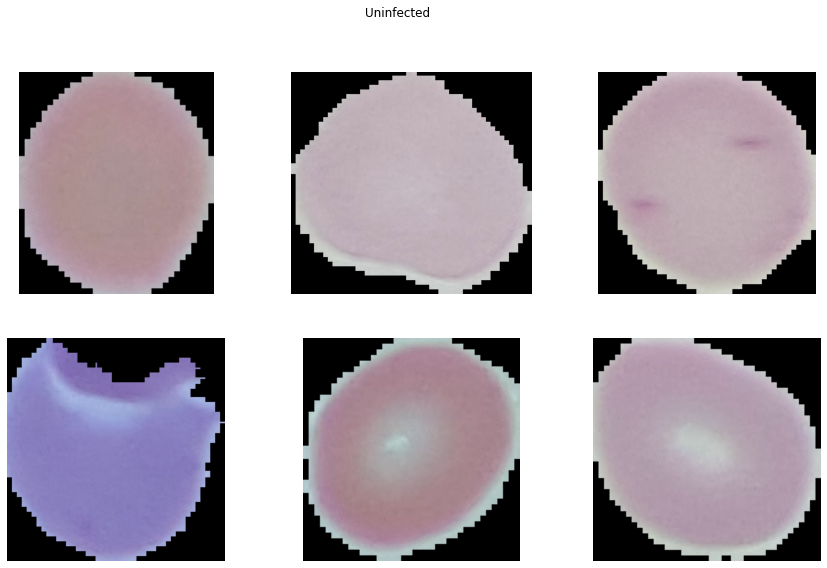

In [9]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

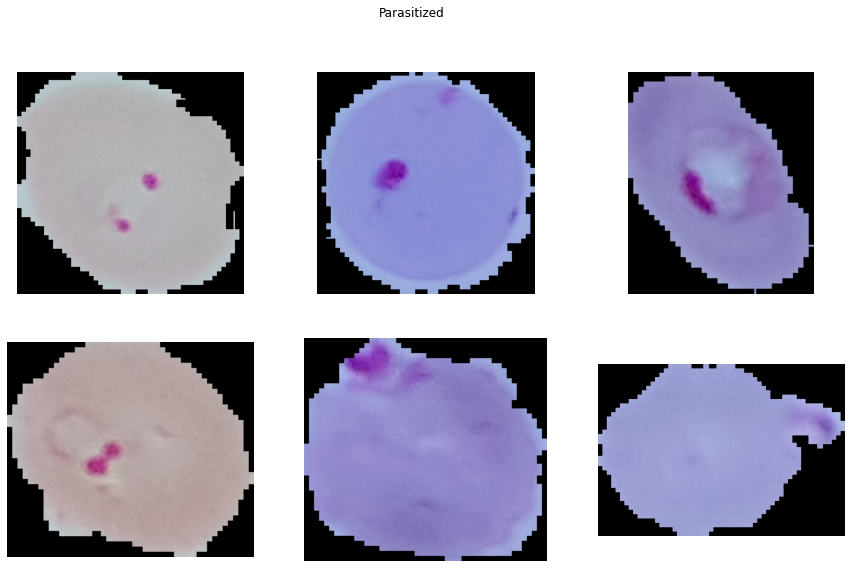

In [10]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()


In [11]:
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [12]:
Cells=np.array(data)
labels=np.array(labels)

In [13]:
np.save("Cells",Cells)
np.save("labels",labels)

In [14]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [15]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [16]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

**Normalizing the dataset**

In [17]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [18]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [19]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed
np.random.seed(0)

**CNN Model**

In [21]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

In [22]:
# compile the model with loss as categorical_crossentropy and using adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

**Training the Model**

In [24]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=32,callbacks=callbacks, validation_data=(x_test,y_test),epochs=20,verbose=1)

Epoch 1/20
776/776 [==============================] - 13s 6ms/step - loss: 0.4001 - accuracy: 0.8009 - val_loss: 0.1818 - val_accuracy: 0.9470
Epoch 2/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1693 - accuracy: 0.9482 - val_loss: 0.1672 - val_accuracy: 0.9517
Epoch 3/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1537 - accuracy: 0.9516 - val_loss: 0.1698 - val_accuracy: 0.9474
Epoch 4/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1469 - accuracy: 0.9539 - val_loss: 0.1569 - val_accuracy: 0.9488
Epoch 5/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1434 - accuracy: 0.9550 - val_loss: 0.1690 - val_accuracy: 0.9437
Epoch 6/20
776/776 [==============================] - 4s 6ms/step - loss: 0.1375 - accuracy: 0.9555 - val_loss: 0.1618 - val_accuracy: 0.9506


In [25]:
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

In [26]:
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 1s 7ms/step - loss: 0.1569 - accuracy: 0.9488
[0.15686999261379242, 0.9488203525543213]


**Test Accuracy**

In [27]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 1s 6ms/step - loss: 0.1569 - accuracy: 0.9488

 Test_Accuracy:- 0.9488203525543213


In [28]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

87/87 [==============================] - 0s 4ms/step


**Evaluation Metrics**

**Confusion Matrix**

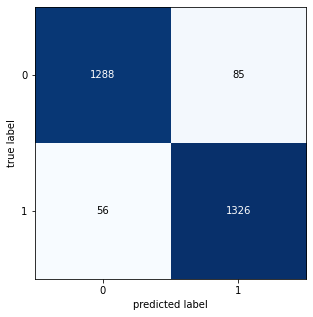

In [29]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [30]:
i=9
pred = model.predict(x_test,batch_size=1)
pred = np.argmax(pred,axis = 1)

2755/2755 [==============================] - 5s 2ms/step


In [31]:
pred[0]

0

**Saving the Model**

In [32]:
model.save('my_model.h5')

**Layers in the CNN Model**

In [33]:
len(model.layers)

13

In [34]:
x_test.shape[0]

2755

**Model Accuracy**

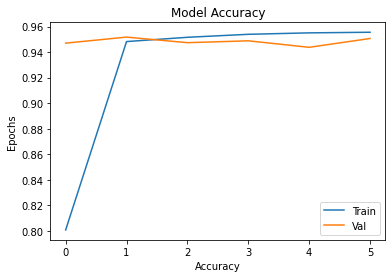

In [35]:
plt.plot(h.history['accuracy'])
plt.plot(h.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

**ROC Curve**

In [36]:
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9487853928830041

In [37]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

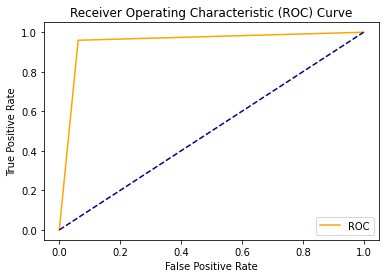

In [38]:
plot_roc_curve(fpr_keras, tpr_keras)

**Classification Report**

In [39]:
from sklearn.metrics import classification_report
print('{}'.format( 
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1373
           1       0.94      0.96      0.95      1382

    accuracy                           0.95      2755
   macro avg       0.95      0.95      0.95      2755
weighted avg       0.95      0.95      0.95      2755



In [40]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
malaria_labels = ['Parasitized','Uninfected']

87/87 [==============================] - 0s 3ms/step


In [41]:
x_test.shape[0]

2755

**Predicting random test images**

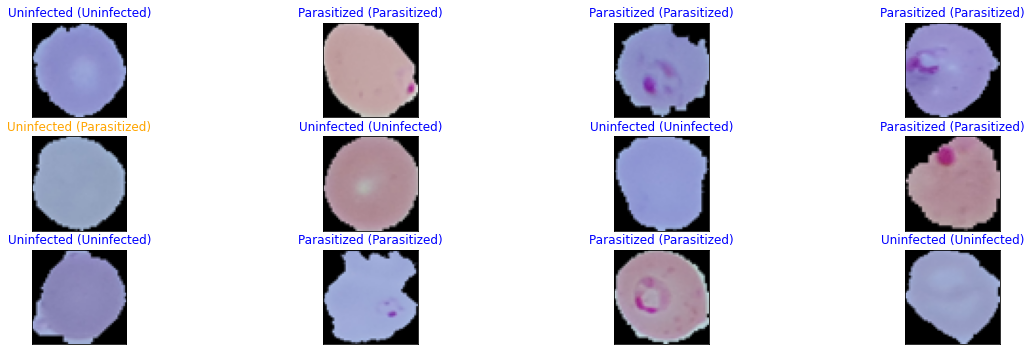

In [42]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

**Deploying the model as Web Application using Streamlit**

In [43]:
%%writefile app.py
import streamlit as st

import cv2
import matplotlib.pyplot as plt 
import os
import numpy as np
import datetime
import itertools
import h5py
import io
from PIL import Image
import tensorflow as tf
from keras.models import load_model
from keras.models import Model

st.set_option('deprecation.showfileUploaderEncoding', False)

@st.cache(allow_output_mutation=True,suppress_st_warning=True)
def load_cnn1():
    model_ = load_model('/content/my_model.h5')
    return model_

def preprocessed_image(file):
    image = file.resize((50,50), Image.ANTIALIAS)
    image = np.array(image)
    image = np.expand_dims(image, axis=0) 
    return image

def main():
    st.title('CNN for Classification Malaria Cells')
    st.sidebar.title('Web Apps using Streamlit')
    st.sidebar.text(""" Project to visualize the CNN layers on malaria-infected image by Aakash Haridas""")
    menu = {1:"Home",2:"Perform Prediction"}
    def format_func(option):
        return menu[option]
    choice= st.sidebar.selectbox("Menu",options=list(menu.keys()), format_func=format_func)
    if choice == 1 :
        st.subheader("Dataset Malaria Cells")
        st.markdown("#### Preliminary")
        """ 
        
        This is datasets of segmented cells from the thin blood smear slide images from the Malaria Screener research activity.
        The Dataset is obtained from researchers at the Lister Hill National Center for Biomedical Communications (LHNCBC),
        part of National Library of Medicine (NLM), that developed a mobile application that runs on a standard Android smartphone attached to a conventional light microscope. 
        Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients were collected and photographed 
        at Chittagong Medical College Hospital, Bangladesh. The smartphone’s built-in camera acquired images of slides for each microscopic field of view. 
        The images were manually annotated by an expert slide reader at the Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand. 
        The de-identified images and annotations are archived at NLM (IRB#12972). then applied a level-set based algorithm to detect and segment the red blood cells. 
        The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells 
        """
        
        st.markdown("#### Previous research")
        """ 
        
        The data appear along with the publications : 
        
        Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR. (2018) 
        Pre-trained convolutional neural networks as feature extractors toward improved Malaria parasite detection in thin blood smear images.
        
        link : https://peerj.com/articles/4568/ 
        
        Rajaraman S, Jaeger S, Antani SK. (2019) Performance evaluation of deep neural ensembles toward malaria parasite detection in thin-blood smear images
        
        link : https://peerj.com/articles/6977/
        """
        
        st.markdown("#### Links for Malaria Dataset")
        """ 
        More information and download links for this Dataset provided below
        
        https://lhncbc.nlm.nih.gov/publication/pub9932
        
        https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
        """

    elif choice == 2 :
        st.subheader("CNN Model")
        st.markdown("#### Simple CNN")
        model_1 = load_cnn1()
        st.subheader('Test on an Image')
        images = st.file_uploader('Upload Image',type=['jpg','png','jpeg'])
        if images is not None:
                images = Image.open(images)
                st.text("Image Uploaded!")
                st.image(images,width=300)
                used_images = preprocessed_image(images)
                predictions = np.argmax(model_1.predict(used_images), axis=-1)
                if predictions == 1:
                    st.error("Cell is normal...The person is healthy")
                elif predictions == 0:
                    st.success("Cell is malaria parasitized...The person has Malaria")
                 
if __name__ == "__main__":
    main()

Writing app.py


In [44]:
!ls

app.py	     cell-images-for-detecting-malaria.zip  labels.npy	 sample_data
cell_images  Cells.npy				    my_model.h5


In [45]:
!pip install -q streamlit

     |████████████████████████████████| 9.2 MB 28.3 MB/s 
     |████████████████████████████████| 164 kB 72.9 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 182 kB 80.1 MB/s 
     |████████████████████████████████| 237 kB 80.3 MB/s 
     |████████████████████████████████| 4.7 MB 61.9 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 


In [46]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.541s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [52]:
!streamlit run /content/app.py &>/content/logs.txt &

**Creating a local tunnel for Web Application**

In [53]:
!npx localtunnel --port 8501

npx: installed 22 in 2.704s
your url is: https://flat-vans-find-35-198-221-90.loca.lt
^C
